# Modelowanie szeregów czasowych

In [1]:
import pandas as pd 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [2]:
# puść ten kod, 
# jeżeli wywołujesz plik  w folderze rozwiąznaia, 
# a ramka danych znajduje się w folderze data
import os 
os.chdir('../')

In [3]:
# Pobranie danych
df_resampled = pd.read_csv('data/sales_resampled.csv',index_col=0)
df_resampled.sort_index(inplace=True)
df_resampled.index = pd.to_datetime(df_resampled.index)

## Test ADF

In [3]:
from statsmodels.tsa.stattools import adfuller

In [4]:
# przeprowadzenie testu
adf_test = adfuller(df_resampled['QTY'],store = True, regresults = True)

In [6]:
# p-value
p_value = adf_test[1]
p_value

np.float64(0.37467777009425257)

In [8]:
# Tworzymy wartość z poprzedniego tygodnia
df_resampled['QTY_1'] = df_resampled['QTY'].shift(1)

In [9]:
# różnice
df_resampled['delta_1'] = df_resampled['QTY'] - df_resampled['QTY_1']

In [10]:
# Test na różnicy
adf_test = adfuller(df_resampled['delta_1'].dropna(),regresults=True,store= True)

In [11]:
adf_test[1]

np.float64(8.169727019158316e-14)

<Axes: xlabel='week_start_date'>

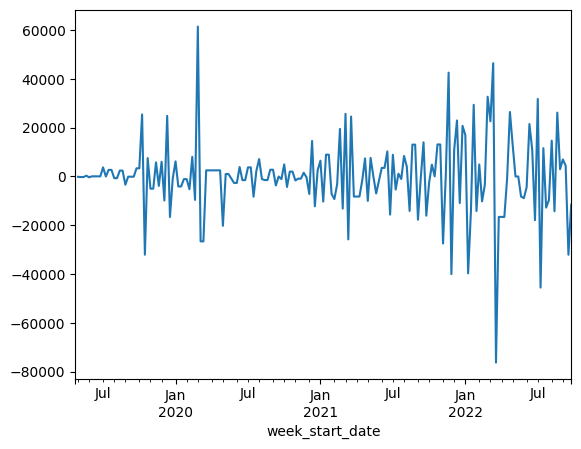

In [12]:
df_resampled['delta_1'].plot()

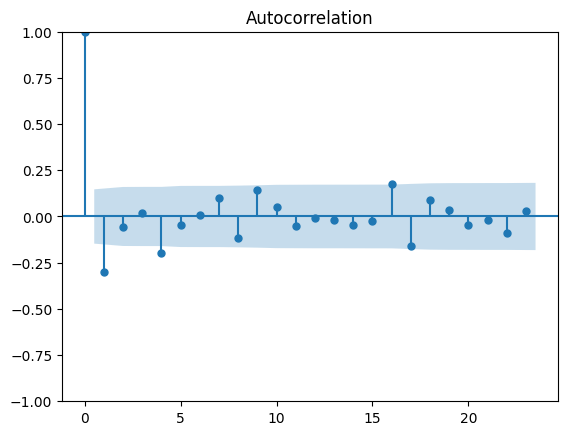

In [ ]:
# q = 1
plot_acf(df_resampled['delta_1'].dropna())
plt.show()

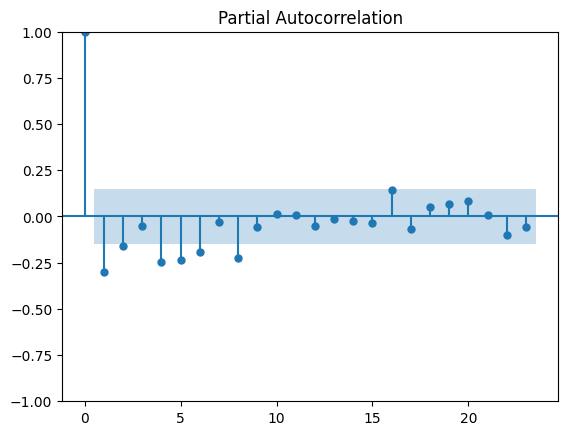

In [ ]:
# p= 2
plot_pacf(df_resampled['delta_1'].dropna())
plt.show()

## Modele

In [18]:
# Uzupełnienie braków danych
df_to_model = df_resampled.dropna()

In [19]:
df_resampled.shape

(179, 4)

In [20]:
df_to_model.shape

(178, 4)

In [21]:
df_resampled['unit_price'] = df_resampled['Total Price'] / df_resampled['QTY']

In [23]:
# model
model = sm.tsa.ARIMA(df_resampled['QTY'], exog = df_resampled['unit_price'], order=(2,1,1))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [24]:
# fit
results = model.fit()

In [25]:
# podsumowanie
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                    QTY   No. Observations:                  179
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1942.197
Date:                Wed, 13 Nov 2024   AIC                           3894.394
Time:                        20:09:23   BIC                           3910.302
Sample:                    04-28-2019   HQIC                          3900.845
                         - 09-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
unit_price  -836.2164    637.311     -1.312      0.189   -2085.324     412.891
ar.L1          0.3725      0.075      4.972      0.000       0.226       0.519
ar.L2         -0.0201      0.093     -0.216      0.8

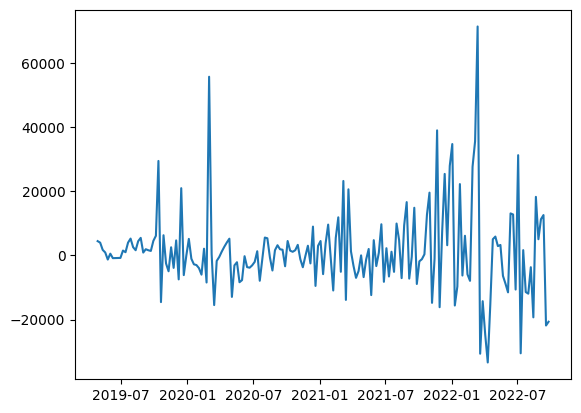

In [26]:
# wykres 
plt.plot(results.resid)

In [36]:
# predykcja
df_resampled['predicted_mean'] = results.predict()

In [33]:
# Funkcja do przygotowania danych do wykresu
def create_forecast_df(results, steps=52):
    forecast = results.get_forecast(steps=steps, exog = np.repeat(df_resampled['unit_price'].median(), steps))
    forecasts  = pd.DataFrame(forecast.predicted_mean)
    forecasts['lower QTY'] = forecast.conf_int()['lower QTY']
    forecasts['upper QTY'] = forecast.conf_int()['upper QTY']
    return forecasts

In [34]:
# Przygotowanie danych
forecasts = create_forecast_df(results)
forecasts.head()

,predicted_mean,lower QTY,upper QTY
2022-10-02,23946.937897,-4038.301038,51932.176831
2022-10-09,29501.479138,-1559.206653,60562.164929
2022-10-16,31285.400812,-669.942905,63240.744529
2022-10-23,31838.440412,-599.900318,64276.781143
2022-10-30,32008.646497,-809.304230,64826.597224


In [37]:
# Historia + forecast
df_to_evaluate = pd.concat([df_resampled, forecasts])

In [38]:
# Funkcja do rysowania wykresu
def plot_model_res(df_to_evaluate):
    plt.plot(df_to_evaluate.index, df_to_evaluate['QTY'], label='actual')
    plt.plot(df_to_evaluate.index, df_to_evaluate['predicted_mean'], label='prediction')
    plt.fill_between(df_to_evaluate.index,
                     df_to_evaluate['lower QTY'],
                     df_to_evaluate['upper QTY'], 
                     color = 'pink',
                     alpha= 0.3)
    plt.legend()
    plt.show()

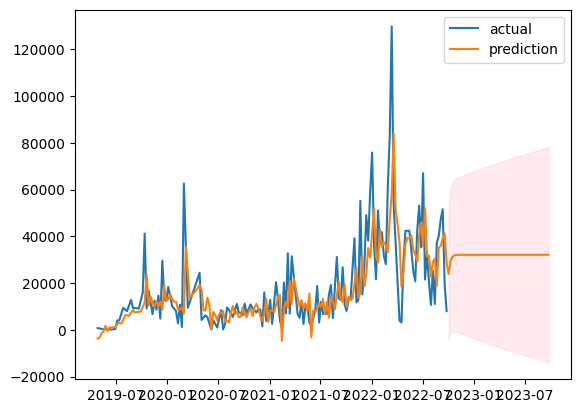

In [39]:
plot_model_res(df_to_evaluate)

## SARIMAX

In [40]:
# model
model_2 = sm.tsa.ARIMA(df_resampled['QTY'], order = (2,1,1), seasonal_order=(1,1,1,52))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [41]:
# fit
results_2 = model_2.fit()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [42]:
# podsumowanie
print(results_2.summary())

                                    SARIMAX Results                                     
Dep. Variable:                              QTY   No. Observations:                  179
Model:             ARIMA(2, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -1393.443
Date:                          Wed, 13 Nov 2024   AIC                           2798.885
Time:                                  20:22:20   BIC                           2815.903
Sample:                              04-28-2019   HQIC                          2805.799
                                   - 09-25-2022                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3455      0.110      3.132      0.002       0.129       0.562
ar.L2          0.0028      0.137      0.020      0.

In [43]:
# Przygotowanie danych
forecasts_2 = create_forecast_df(results_2)

In [44]:
forecasts_2

,predicted_mean,lower QTY,upper QTY
2022-10-02,23899.012524,-10564.508036,58362.533083
2022-10-09,30439.791262,-7155.410867,68034.993390
2022-10-16,30205.279292,-8317.475734,68728.034317
2022-10-23,37195.510675,-1801.167502,76192.188853
2022-10-30,40676.818564,1330.493598,80023.143531
2022-11-06,30115.697855,-9539.696140,69771.091851
2022-11-13,30521.137457,-9428.288682,70470.563597
2022-11-20,45991.944326,5755.008701,86228.879950
2022-11-27,32273.896585,-8246.981542,72794.774712
2022-12-04,31358.430255,-9443.879623,72160.740132


In [45]:
df_resampled['predicted_mean'] = results_2.predict()

In [46]:
# Złaczenie danych
df_to_evaluate_2 = pd.concat([df_resampled,forecasts_2])

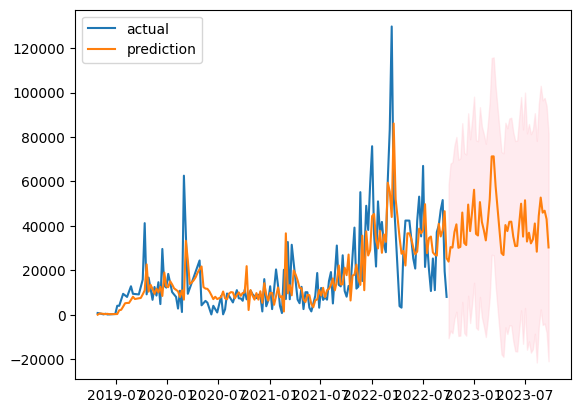

In [47]:
# Narysowanie wykresu
plot_model_res(df_to_evaluate_2)